In [26]:
# IPython candies...
from IPython.display import Image
from IPython.core.display import HTML 

In [27]:
# Imports we need.
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

Seq2Seq with PyTorch
====

Sequence-to-Sequence (Seq2Seq) learning is a useful class of neural network model to map sequential input into an output sequence. It has been shown to work well on various task, from machine translation to interpreting Python without an interpreter. {{citations-needed}}

This notebook is a hands-on session to write an encoder-decoder Seq2Seq network using PyTorch for [DataScience SG meetup](https://www.meetup.com/DataScience-SG-Singapore/events/246541733/). Here's the accompanying slides for this notebook: https://goo.gl/Lu6CxB


It would be great if you have at least worked through the ["Deep Learning in 60 minutes" PyTorch tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before continuing the rest of the notebook.




Acknowledgements
----

The dataset used in this exercise is hosted on https://www.kaggle.com/alvations/sg-kopi

The materials of this notebook and the accompanying slides are largely based on the 

 - [PyTorch Seq2Seq tutorials by Sean Robertson](http://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html) and 
 - [Luong et al. tutorial on neural machine translation in ACL16](https://sites.google.com/site/acl16nmt/home).



Kopi Problems
====

In this hands-on session, we want to **train a neural network to translate from Singlish Kopi orders to English?**


**"Singlish" -> English**

```
"Kopi" -> Coffee with condensed milk
"Kopi O" -> Coffee without milk or sugar
"Kopi dinosaur gau siew dai peng" -> ???
```

(Image Source: http://www.straitstimes.com/lifestyle/food/get-your-kopi-kick)

In [28]:
Image(url="https://static.straitstimes.com.sg/sites/default/files/160522_kopi.jpg", width=700)

Seriously?
----

Yes, we'll be translating Singlish Kopi orders to English using the [sequence-to-sequence network](https://arxiv.org/abs/1409.3215) (Sutskever et al. 2014).


But first...
---

1. Data Munging
====

Before any machine/deep learning, we have to get some data and "hammer" it until we get it into the shape we want.

> *Data scientists spend 60% of their time on cleaning and organizing data. Collecting data sets comes second at 19% of their time, meaning data scientists spend around 80% of their time on preparing and managing data for analysis.*

> (Source: [Gil Press](https://www.forbes.com/sites/gilpress/2016/03/23/data-preparation-most-time-consuming-least-enjoyable-data-science-task-survey-says/#3e4dc0416f63) Forbes article)

**Step 1:** Take the data from somewhere, in this case: http://kaggle.com/alvations/sg-kopi.

**Step 2:** Import your favorite dataframe and text processing library.

**Step 3:** Munge the data till desired.

In [29]:
import pandas as pd
from gensim.corpora.dictionary import Dictionary
from nltk import word_tokenize

# Reads the tab-delimited data using Pandas.
kopitiam = pd.read_csv('kopitiam.tsv', sep='\t')
kopitiam.head()

,Local Terms,Meaning,Source
0,Kopi O,Black Coffee with Sugar,https://daneshd.com/2010/02/28/a-rough-guide-t...
1,Kopi,Black Coffee with Condensed Milk,https://daneshd.com/2010/02/28/a-rough-guide-t...
2,Kopi C,Black Coffee with Evaporated Milk,https://daneshd.com/2010/02/28/a-rough-guide-t...
3,Kopi Kosong,Black Coffee without sugar or milk,https://daneshd.com/2010/02/28/a-rough-guide-t...
4,Kopi Gah Dai,Black Coffee with extra condensed milk,https://daneshd.com/2010/02/28/a-rough-guide-t...


1.1. Reshaping the Data and Adding START and END Symbols
----

To get the data in shape, we want to:
  
  1. normalize and tokenize of the input
  2. pad the input with START (`<s>`) and END (`<\s>`) symbols.

If we look at the data carefully, sometimes we see that we have a mix of capitalized and lowered cased spellings, esp. in the "Local Terms" column. E.g. "Kopi O" and "Kopi o". For simplicity, we'll lowercase all the inputs and outputs so that our models don't think that the big "O" and the small "o" are different things.

Additionally, we want to tokinze our input so that we pad the punctuations with spaces away from the preceeding or following word. There are many tokenization functions, we'll use the `word_tokenize()` function in `nltk`.

As for padding the sentence with START and END symbols. It's an indication that we give to our Recurrent Neural Network (RNN) that denotes the start/end of our in/output sequences. 


(**Cut-away:** Here's some experts pitching in on why we need the START/END symbol. https://twitter.com/alvations/status/955770616648364037) 

TL;DR
----

Given, $[in]$:

```
kopi o
black coffee with sugar
```

We want, $[out]$:

```
['<s>', 'kopi', 'o', '</s>']
['<s>', 'black', 'coffee', 'with', 'sugar', '</s>']
```

In [30]:
# Use a unique string to indicate START and END of a sentence.
# Assign a unique index to them.
START, START_IDX = '<s>',  0
END, END_IDX = '</s>', 1

# We use this idiom to tokenize our sentences in the dataframe column:
# >>> DataFrame['column'].apply(str.lower).apply(word_tokenize)

# Also we added the START and the END symbol to the sentences. 
singlish_sents = [START] + kopitiam['Local Terms'].apply(str.lower).apply(word_tokenize) + [END]
english_sents = [START] + kopitiam['Meaning'].apply(str.lower).apply(word_tokenize) + [END]

# We're sort of getting into the data into the shape we want. 
# But now it's still too humanly readable and redundant.
## Cut-away: Computers like it to be simpler, more concise. -_-|||
print('First Singlish sentence:', singlish_sents[0])
print('First English sentence:', english_sents[0])

First Singlish sentence: ['<s>', 'kopi', 'o', '</s>']
First English sentence: ['<s>', 'black', 'coffee', 'with', 'sugar', '</s>']


1.1.2 Vectorize the Data
----

There are many ways to vectorize text data. And since we are going to use RNN which requires the order of the sequences to be kept, we can simply convert our vocabulary (unique words) in the data into an indexed dictionary and replace each sentence as a list of indices. 

Thankfully, we don't have to write messy classes to create objects that stores these dictionary of indices to the respective words. We have the awesome `gensim` library and the [gensim.corpora.Dictionary](https://radimrehurek.com/gensim/corpora/dictionary.html) class.

> **Note:** 
>
> We want to `<s>` and `<\s>` to take the 0th and 1st indices so we first initialize a sentence with only the `<s>` symbol and another sentence with `<\s>` to prevent the native Python dictionary hashing that messes up the order of a set. 
> 
> So we'll do `Dictionary([['<s>'], ['</s>'], ['UNK']])` before we use `Dictionary.add_documents()`.
>
> To convert the input sequence of tokens into list of indices we use the [`Dictionary.doc2idx()`](https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2idx) function.



TL;DR
----

Given this $[in]$:

```
['<s>', 'kopi', 'o', '</s>']
['<s>', 'black', 'coffee', 'with', 'sugar', '</s>']
```


We want $[out]$:

```
[0, 3, 4, 1]
[0, 3, 4, 6, 5, 1]
```


In [31]:
# Let's convert the individual words into some sort of unique index 
# and use the unique to represent the words. 
## Cut-away: Integers = 1-2 bytes vs UTF-8 Strings = no. of chars * 1-2 bytes. @_@

english_vocab = Dictionary([['<s>'], ['</s>']])
english_vocab.add_documents(english_sents)

singlish_vocab = Dictionary([['<s>'], ['</s>']])
singlish_vocab.add_documents(singlish_sents)

# First ten words in the vocabulary.
print('First 10 Singlish words in Dictionary:\n', sorted(singlish_vocab.items())[:10])
print()
print('First 10 English words in Dictionary:\n', sorted(english_vocab.items())[:10])

First 10 Singlish words in Dictionary:
 [(0, '<s>'), (1, '</s>'), (2, 'kopi'), (3, 'o'), (4, 'c'), (5, 'kosong'), (6, 'dai'), (7, 'gah'), (8, 'siew'), (9, 'po')]

First 10 English words in Dictionary:
 [(0, '<s>'), (1, '</s>'), (2, 'black'), (3, 'coffee'), (4, 'sugar'), (5, 'with'), (6, 'condensed'), (7, 'milk'), (8, 'evaporated'), (9, 'or')]


In [ ]:
# Lets save our dictionaries.
with open('singlish_vocab.Dictionary.pkl', 'wb') as fout:
    pickle.dump(singlish_vocab, fout)
    
with open('english_vocab.Dictionary.pkl', 'wb') as fout:
    pickle.dump(english_vocab, fout)

In [32]:
# Now, convert all the sentences into list of the indices 
print('First Singlish sentence:')
print(singlish_sents[0])
print(singlish_vocab.doc2idx(singlish_sents[0]), end='\n\n')

print('First English sentence:')
print(english_sents[0])
print(english_vocab.doc2idx(english_sents[0]))

First Singlish sentence:
['<s>', 'kopi', 'o', '</s>']
[0, 2, 3, 1]

First English sentence:
['<s>', 'black', 'coffee', 'with', 'sugar', '</s>']
[0, 2, 3, 5, 4, 1]


In [33]:
# Lets create a function to convert new sentences into the indexed forms.
def vectorize_sent(sent, vocab):
    return vocab.doc2idx([START] + word_tokenize(sent.lower()) + [END])

new_kopi = "Kopi dinosaur gau siew dai peng"
vectorize_sent(new_kopi, singlish_vocab)

[0, 2, 21, 10, 8, 6, 11, 1]

1.1.3. Clobbering the Data into PyTorch Variable
----

For the last step of data hammering, we need to clobber the vectorized sentence into PyTorch `Variable` type. 

**Note:** Before continuing this notebook, you're strongly encourage to go through the following if you're unfamiliar with PyTorch:
http://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_autograd.html

In [34]:
def variable_from_sent(sent, vocab):
    vsent = vectorize_sent(sent, vocab)
    result = Variable(torch.LongTensor(vsent).view(-1, 1))
    return result.cuda() if use_cuda else result

new_kopi = "Kopi dinosaur gau siew dai peng"
variable_from_sent(new_kopi, singlish_vocab)

Variable containing:
    0
    2
   21
   10
    8
    6
   11
    1
[torch.LongTensor of size 8x1]

In [35]:
# To get the sentence length.
variable_from_sent(new_kopi, singlish_vocab).size()[0] # Includes START and END symbol.

8

In [38]:
# Prepare the whole training corpus.
singlish_tensors = kopitiam['Local Terms'].apply(lambda s: variable_from_sent(s, singlish_vocab))
english_tensors = kopitiam['Meaning'].apply(lambda s: variable_from_sent(s, english_vocab))

# Now, each item in `sent_pairs` is our data point. 
sent_pairs = list(zip(singlish_tensors, english_tensors))

2. The Seq2Seq Model
====

A Recurrent Neural Network (RNN), is a network that operates on a sequence and uses its own output as input for subsequent steps.

> *The general idea is to make **two recurrent neural network transform from one sequence to another**. An encoder network condenses an input sequence into a vector and a decoder netwrok unfolds the vector into a new sequence.*



2.1. The Encoder
====

The encoder of a seq2seq network is a RNN that outputs some value for every word from the input sentence. For every input word the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word.


<img src="http://pytorch.org/tutorials/_images/encoder-network.png" align='left'>

In [39]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        # Set the no. of nodes for the hidden layer.
        self.hidden_size = hidden_size
        # Initialize the embedding layer with the 
        # - size of input (i.e. no. of words in input vocab)
        # - no. of hidden nodes in the embedding layer
        self.embedding = nn.Embedding(input_size, hidden_size)
        # Initialize the GRU with the 
        # - size of the hidden layer from the previous state
        # - size of the hidden layer from the current state
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        # Feed the input into the embedding layer.
        embedded = self.embedding(input).view(1, 1, -1)
        # Feed the embedded layer with the hidden layer to the GRU.
        # Update the output and hidden layer.
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def initialize_hidden_states(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        return result.cuda() if use_cuda else result


2.2. Simple Decoder
====

In the simplest seq2seq decoder we use only last output of the encoder. This last output is sometimes called the context vector as it encodes context from the entire sequence. This context vector is used as the initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and hidden state. The initial input token is the start-of-string `<s>` token, and the first hidden state is the context vector (the encoder’s last hidden state).


<img src="http://pytorch.org/tutorials/_images/decoder-network.png" align='left'>


In [40]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        # Set the no. of nodes for the hidden layer.
        self.hidden_size = hidden_size
        # Initialize the embedding layer with the 
        # - size of output (i.e. no. of words in output vocab)
        # - no. of hidden nodes in the embedding layer
        self.embedding = nn.Embedding(output_size, hidden_size)
        # Initialize the GRU with the 
        # - size of the hidden layer from the previous state
        # - size of the hidden layer from the current state
        self.gru = nn.GRU(hidden_size, hidden_size)
        # Set the output layer to output a specific symbol 
        # from the output vocabulary
        self.softmax = nn.LogSoftmax(dim=1)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        # Feed the input into the embedding layer.
        output = self.embedding(input).view(1, 1, -1)
        # Transform the embedded output with a relu function. 
        output = F.relu(output)
        # Feed the embedded layer with the hidden layer to the GRU.
        # Update the output and hidden layer.
        output, hidden = self.gru(output, hidden)
        # Take the updated output and find the most appropriate
        # output symbol. 
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initialize_hidden_states(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        return result.cuda() if use_cuda else result
        

2.3. Training the Model
====

To train we run the input sentence through the encoder, and keep track of every output and the latest hidden state. Then the decoder is given the `<s>` token as its first input, and the last hidden state of the encoder as its first hidden state.

2.3.1 Set the Hyperparamters and Prepare Data (again...)
----

As with all gradient methods in deep/machine learning, the basic idea is to:

 1. Iterate through **batch_size** data points **epochs** no. of times
 2. For each batch of data, calculate the **loss** between the (i) predicted output (y_hat) given the inputs (x) and (ii) the actual output (y). For deep learning models, **backpropagate** the loss
 3. Make the **optimizer** take a step based on the **learning_rate** and the **backpropagated** losses
 4. Repeat Step 1-3 until certain stopping criteria (e.g. the loss is no longer reducing or is taking an upwards trend or until a fix no. of epochs is completed)
 
 

**Note:** If you're unfamiliar with the steps above, I strongly encourage you to:

 - Watch @sirajraval on https://www.youtube.com/embed/q555kfIFUCM and 
 - Spend some time going through this blogpost by @iamtrask http://iamtrask.github.io/2015/07/12/basic-python-network/



In [41]:
hidden_size = 10
learning_rate=0.01
batch_size = 2
epochs = 30 # Since we are taking batch_size=2 and epochs=30, we only look at 60 data points.
criterion = nn.NLLLoss()
MAX_LENGTH=20

# Initialize the network for encoder and decoder.
input_vocab, output_vocab = singlish_vocab, english_vocab
encoder = EncoderRNN(len(input_vocab), hidden_size)
decoder = DecoderRNN(hidden_size, len(output_vocab))
if use_cuda:
    encoder = encoder.cuda()
    decoder = decoder.cuda()

# Initialize the optimizer for encoder and decoder.
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

# If batchsize == 1, choose 1 data points per batch:
##training_data = [[random.choice(sent_pairs)] for i in range(epochs)]

# If batch_size > 1, use random.sample() instead of random.choice:
training_data = [random.sample(sent_pairs, batch_size) for i in range(epochs)]

2.3.2. Loop through the batches
---

To start the model training, first we iterate through the batches.

In [16]:
#############################################
# 2.3.2. Loop through the batches.
#############################################
# Start the training.
for data_batch in training_data:
    # (Re-)Initialize the optimizers, clear all gradients after every batch.
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    # Reset the loss for every batch.
    loss = 0
    for input_variable, target_variable in data_batch:
        # Initialize the hidden_states for the encoder.
        encoder_hidden = encoder.initialize_hidden_states()
        # Initialize the length of the PyTorch variables.
        input_length = input_variable.size()[0]
        target_length = target_variable.size()[0]
        encoder_outputs = Variable(torch.zeros(MAX_LENGTH, encoder.hidden_size))
        encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

2.3.3. Iterating through each word in the encoder.
----

Moving on, for each batch, we iterate through the data points (i.e. sentence pairs).

In [42]:
#############################################
# 2.3.2. Loop through the batches.
#############################################
# Start the training.
for data_batch in training_data:
    # (Re-)Initialize the optimizers, clear all gradients after every batch.
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    # Reset the loss for every batch.
    loss = 0
    for input_variable, target_variable in data_batch:
        # Initialize the hidden_states for the encoder.
        encoder_hidden = encoder.initialize_hidden_states()
        # Initialize the length of the PyTorch variables.
        input_length = input_variable.size()[0]
        target_length = target_variable.size()[0]
        encoder_outputs = Variable(torch.zeros(MAX_LENGTH, encoder.hidden_size))
        encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs
        #############################################
        # 2.3.3.  Iterating through each word in the encoder.
        #############################################
        # Iterating through each word in the input.
        for ei in range(input_length):
            # We move forward through each state.
            encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
            # And we save the encoder outputs. 
            # Note: We're retrieving [0][0] cos remember the weird .view(1,1,-1) for the GRU.
            encoder_outputs[ei] = encoder_output[0][0] 

2.3.3.1. Outputs of the Encoder
----

Before we move on with the training data, we should take a look at the coolest feature of PyTorch (aka Tensorflow Eager mode way before eager mode is a thing). 

The fact that we can hijack the training process and start printing out layer output values or current parameters without needing to wait till the end of the training is pretty powerful. 

This is an artifact of how the PyTorch library designer allows users to probe and change the network at any point of time without first declaring and fixing a specific network. 

**Cut-away:** Here's some heated blogpost of imperative/declarative programming style.

- Funny yet Informative: https://tylermcginnis.com/imperative-vs-declarative-programming/

- Simple Python is de facto imperative but it's possible to do otherwise: http://www.benfrederickson.com/python-as-a-declarative-programming-language/

<!--
Pardon me being frank (not hotdog)
----

IMHO, I (Liling) don't really care how I write my network as long as the library allows me to have flexibility to alter networks and training mechanisms to suit what I'm trying to do. And for now, I write less code to do the same thing in PyTorch, so yeah... -->

----

Lets take a look at the last sentence we processed with the code above (Section 2.3.3.)
----

In [19]:
# The encoded output for the last sentence in out training_data"

# The encoder has 68 unique words
print(encoder, '\n')
print(singlish_vocab)
print('\n########\n')

EncoderRNN(
  (embedding): Embedding(68, 10)
  (gru): GRU(10, 10)
) 

Dictionary(68 unique tokens: ['<s>', '</s>', 'UNK', 'kopi', 'o']...)

########



In [20]:
# The last input sentence, in PyTorch Tensor data structure.
print(data_batch[-1][0]) 
print('########\n')


Variable containing:
  0
 14
  4
  6
  1
[torch.LongTensor of size 5x1]

########



In [21]:

# The last input sentence as list(int)
print(list(map(int, data_batch[-1][0])), '\n')
print('########\n')

# The last input sentence as list(int)
print(' '.join([singlish_vocab[i] for i in map(int, data_batch[-1][0])]))
print('\n########\n')


[0, 14, 4, 6, 1] 

########

<s> teh o kosong </s>

########



In [22]:

# The encoded outputs of the last sentence 
# Note: We have a matrix of 20 (MAX_LENGTH) x 10 (hidden_size) and 
#       for this particular sentence, we only have 4 encoded outputs
print(encoder_outputs)

Variable containing:
-0.1214  0.2326 -0.3078 -0.0045 -0.0870  0.0150  0.4273  0.3584  0.1007  0.2582
-0.0815  0.2332 -0.4338 -0.3060  0.0044  0.1103  0.5286 -0.0093  0.4035  0.1736
-0.6873  0.0396  0.3701 -0.7467 -0.1440 -0.4195  0.5479  0.2969  0.4136 -0.0482
-0.4481  0.3308 -0.2921 -0.4302 -0.5618 -0.2736  0.3295  0.1484  0.5261  0.0894
 0.1654  0.2799  0.1352 -0.2455  0.0506 -0.1016 -0.3219 -0.3612  0.3636 -0.1309
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
 0.0000  0.0000  0.

**Note:** We see only 5 rows are populated. With each rows representing the encoded output of the individual states as we step through the RNN. And the final row `encoded_outputs` will correspond to the `encoder_hidden`, i.e.

In [44]:
# The last hidden state of the last input sentence. 
# Note: For vanilla RNN (Elman Net), the last hidden state of the encoder
#       is the start state of the decoder's hidden state.
print(encoder_hidden)

Variable containing:
(0 ,.,.) = 

Columns 0 to 8 
  -0.0078 -0.5923  0.6164  0.1475 -0.5511  0.6830  0.5584  0.0438  0.3793

Columns 9 to 9 
  -0.0317
[torch.FloatTensor of size 1x1x10]



2.3.4. Iterating through each word in the decoder.
----

After encoding, we 

 1. initialize the start of the decoder input with the index of our START symbol.
 2. use the final encoded hidden state as the start of the decoder hidden state, i.e. `decoder_hidden = encoder_hidden`. 
 3. step through the state, i.e. `decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)`
 4. we map the softmax output (negative log probabilities to the words) and choose the best prediction as the predicted word for the current state, i.e. `topv, topi = decoder_output.data.topk(1); ni = topi[0][0]`
 5. as we move through the decoder states (i.e. as we predict the previous words), we use the newly predicted word as the input to the next state, i.e. `decoder_input = Variable(torch.LongTensor([ni]))`

In [19]:
#############################################
# 2.3.2. Loop through the batches.
#############################################
# Start the training.
for data_batch in training_data:
    # (Re-)Initialize the optimizers, clear all gradients after every batch.
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    # Reset the loss for every batch.
    loss = 0
    for input_variable, target_variable in data_batch:
        # Initialize the hidden_states for the encoder.
        encoder_hidden = encoder.initialize_hidden_states()
        # Initialize the length of the PyTorch variables.
        input_length = input_variable.size()[0]
        target_length = target_variable.size()[0]
        encoder_outputs = Variable(torch.zeros(MAX_LENGTH, encoder.hidden_size))
        encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs
        
        #############################################
        # 2.3.3.  Iterating through each word in the encoder.
        #############################################
        # Iterating through each word in the input.
        for ei in range(input_length):
            # We move forward through each state.
            encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
            # And we save the encoder outputs. 
            # Note: We're retrieving [0][0] cos remember the weird .view(1,1,-1) -_-|||
            encoder_outputs[ei] = encoder_output[0][0] 
            
            #############################################
            # 2.3.4.  Iterating through each word in the decoder.
            #############################################
            # Initialize the variable input with the index of the START.
            decoder_input = Variable(torch.LongTensor([[START_IDX]]))
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input
            # As the first state of the decoder, we take the last step of the encoder.
            decoder_hidden = encoder_hidden
            # Iterate through each state in the decoder.
            # Note: when we are training we know the length of the decoder.
            #       so we can use the trick to restrict the loop when decoding.
            for di in range(target_length):
                # We move forward through each state.
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
                # What are all these weird syntax, refer to 2.3.4.1
                topv, topi = decoder_output.data.topk(1)
                ni = topi[0][0]

                # Replace our decoder input for the next state with the
                # embedding of the decoded topi guess. 
                decoder_input = Variable(torch.LongTensor([[ni]]))
                decoder_input = decoder_input.cuda() if use_cuda else decoder_input
                
                # Update our loss for this batch.
                loss += criterion(decoder_output, target_variable[di])
                
                # If we see the </s> symbol, break the training.
                if ni == END_IDX:
                    break


2.3.4.1 Outputs of the Decoder
----

Once again, we hijack the training process and take a look at what we're doing at the docoder. 

Here we see the last sentence in our training_data in the previous jupyter notebook cell:

In [45]:
# Cut-away: The decoded output for the last sentence in out training_data"

# The encoder has 117 unique words
print(decoder, '\n')
print(english_vocab)
print('\n########\n')

# The last input sentence.
print(' '.join([singlish_vocab[i] for i in map(int, data_batch[-1][0])]))
# The last target sentence.
print(' '.join([english_vocab[i] for i in map(int, data_batch[-1][1])]))

print('\n########\n')

DecoderRNN(
  (embedding): Embedding(116, 10)
  (gru): GRU(10, 10)
  (softmax): LogSoftmax()
  (out): Linear(in_features=10, out_features=116)
) 

Dictionary(116 unique tokens: ['<s>', '</s>', 'black', 'coffee', 'sugar']...)

########

<s> tai ga ho </s>
<s> horlicks </s>

########



How did we arrive at the predicted word from decoder_output?
-----

We look at the `decoder_output.data` that shows a vector of 117 columns, each column correspond to the target word that we are predicting. The values are negative log probabilities.

Then the `decoder_output.topk`, will filter and leave the topk predictions based on the vector of negative log probabilities. 

The `decoder_output.topk` will return a list of tuples were the first item is the score (i.e. negative log probability) and the second item is the index of the word for the target vocabulary. 

In [21]:
# The last word in the last sentence. 
print([english_vocab[i] for i in map(int, data_batch[-1][1])][-1])
print('\n########')

# The -log probability of the word that's most probably the 
# correct target word as we moved from the encoder to the decoder.
print(decoder_output.data)

print('\n########')

# The word with the highest probability
print(decoder_output.data.topk(1))
print('\n########')

# Take a look at what's the decoder's guess for the final word in the last sentence.
topv, topi = decoder_output.data.topk(1)
print(topv) # The -log probability of the decoder's guess.
print(topi) # The index of the word in the english_vocab.
print(english_vocab[int(topi)]) # Decoder's guess of the final word.


</s>

########


Columns 0 to 9 
-4.9682 -5.1267 -5.6028 -4.0663 -4.5102 -4.4591 -4.9175 -5.0732 -5.0293 -5.3705

Columns 10 to 19 
-5.0894 -4.9453 -4.6394 -4.9664 -5.1267 -4.4543 -5.0366 -4.8566 -4.6203 -4.9958

Columns 20 to 29 
-4.7038 -4.5959 -4.7804 -4.8709 -5.0501 -4.8864 -4.8876 -5.0000 -4.6976 -4.6324

Columns 30 to 39 
-4.4754 -5.4241 -4.5974 -4.6645 -4.7227 -4.9907 -5.0174 -4.8825 -4.9364 -4.7163

Columns 40 to 49 
-5.0280 -5.0492 -4.6629 -5.1601 -4.3666 -4.3587 -4.8414 -4.7386 -4.4162 -4.6509

Columns 50 to 59 
-4.7710 -4.9370 -4.4109 -4.6621 -4.6100 -4.8891 -4.8433 -4.4666 -4.8315 -4.4337

Columns 60 to 69 
-4.6725 -4.8010 -4.5824 -4.7252 -4.5903 -4.8131 -4.2811 -5.3550 -5.5460 -4.8272

Columns 70 to 79 
-5.2190 -4.6178 -4.9321 -5.2433 -4.6670 -4.0502 -4.4425 -4.5862 -4.6299 -4.5233

Columns 80 to 89 
-5.2702 -4.7900 -5.3953 -4.6982 -4.4740 -4.9680 -4.4162 -5.1073 -4.9964 -4.5141

Columns 90 to 99 
-5.1502 -4.7556 -4.3382 -4.8319 -4.6833 -4.7920 -4.5417 -4.5824 -4.7229 -4.4

2.3.5 Backpropagate the Loss and Optimizers Takes a Step.
----

The "magic" of deep learning libraries like PyTorch, Tensorflow, DyNet, etc. is that we don't have to write our own derivative and recursive backpropagation functions. 

In PyTorch, we simply do something like:

```python
>>> criterion = nn.NLLLoss()
>>> ... ... (yada yada network)
>>> loss += criterion(decoder_output, target_variable[di])
>>> loss.backward() 
>>> optimizer.step()
```

## Viva la backpropaganda!

In [29]:
#############################################
# 2.3.2. Loop through the batches.
#############################################
# Start the training.
for data_batch in training_data:
    # (Re-)Initialize the optimizers, clear all gradients after every batch.
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    # Reset the loss for every batch.
    loss = 0
    for input_variable, target_variable in data_batch:
        # Initialize the hidden_states for the encoder.
        encoder_hidden = encoder.initialize_hidden_states()
        # Initialize the length of the PyTorch variables.
        input_length = input_variable.size()[0]
        target_length = target_variable.size()[0]
        encoder_outputs = Variable(torch.zeros(MAX_LENGTH, encoder.hidden_size))
        encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs
        
        #############################################
        # 2.3.3.  Iterating through each word in the encoder.
        #############################################
        # Iterating through each word in the input.
        for ei in range(input_length):
            # We move forward through each state.
            encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
            # And we save the encoder outputs. 
            # Note: We're retrieving [0][0] cos remember the weird .view(1,1,-1) -_-|||
            encoder_outputs[ei] = encoder_output[0][0] 
            
            #############################################
            # 2.3.4.  Iterating through each word in the decoder.
            #############################################
            # Initialize the variable input with the index of the START.
            decoder_input = Variable(torch.LongTensor([[START_IDX]]))
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input
            # As the first state of the decoder, we take the last step of the encoder.
            decoder_hidden = encoder_hidden
            # Iterate through each state in the decoder.
            # Note: when we are training we know the length of the decoder.
            #       so we can use the trick to restrict the loop when decoding.
            for di in range(target_length):
                # We move forward through each state.
                decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
                # What are alll these weird syntax, refer to 2.3.4.1
                topv, topi = decoder_output.data.topk(1)
                ni = topi[0][0]

                # Replace our decoder input for the next state with the
                # embedding of the decoded topi guess. 
                decoder_input = Variable(torch.LongTensor([[ni]]))
                decoder_input = decoder_input.cuda() if use_cuda else decoder_input
                
                # Update our loss for this batch.
                loss += criterion(decoder_output, target_variable[di])
                
                # If we see the </s> symbol, break the training.
                if ni == END_IDX:
                    break
    #####################################################
    # 2.3.5 Backpropagate the Loss and Optimizers Takes a Step.
    #####################################################
    loss.backward() # Backpropagate.
    encoder_optimizer.step()
    decoder_optimizer.step()


Let's try translating with the small model
====

It's good to note that the model has only seen 60 random data pairs of singlish and english sentences using these hyperparameters:

```
hidden_size = 10
learning_rate=0.01
batch_size = 2
epochs = 30 # Since we are taking batch_size=2 and epochs=30, we only look at 60 data points.
criterion = nn.NLLLoss()
MAX_LENGTH=20
```



2.3.6 Getting the Model to Translate
====

Remember that during training, our decode takes the `encoder_hidden` as in start state of the `decoder_hidden` and starts predicting the words as we move along the decoder states?

Similarly, when translating input sentences with no target sentences, we'll do the same prediction in the decoder but the only difference is that we **DON'T** need to:

- measure the difference between the prediction and the actual target sentence since we don't have it, (i.e. we don't need to do `criterion(decoder_output, target_variable[di])`) and
- backpropagate nor update the loss
- do anything to the optimizer


You can see that the `translator()` function is very much like our `train_one_epoch` code, we added:

 - the need to keep a list of the decoded words' indices
 - instead of returning the loss, we return the list of decoded word indices


In [97]:
def translator(encoder, decoder, input_variable, max_length=MAX_LENGTH):
    # The length of the input.
    input_length = input_variable.size()[0]
    # For each sentence, initilize the hidden states with zeros.
    encoder_hidden = encoder.initialize_hidden_states()
    # Initialize the encoder outputs. 
    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs
    # Iterate through the input words.
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
    # Initialize the decoder with the start symbol <s>.
    decoder_input = Variable(torch.LongTensor([[START_IDX]])) 
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    # Use the last encoder hidden state as the first decoder's hidden state.
    decoder_hidden = encoder_hidden
    # Keep a list of the decoded words.
    decoded_words = []
    
    # Iterate through the decoder states.
    for di in range(max_length):
        # Very similar to how the training works.
        decoder_output, decoder_hidden = decoder(decoder_input, 
                                                 decoder_hidden)
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == END_IDX:
            decoded_words.append(END_IDX)
            break
        else:
            decoded_words.append(ni)
        # Replace the new decoder input for the next state 
        # with the top guess of this state.
        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    return decoded_words

In [98]:
sent = 'kopi siew dai'
variable_from_sent(sent, singlish_vocab)

Variable containing:
 0
 2
 8
 6
 1
[torch.LongTensor of size 5x1]

In [99]:
output_words = translator(my_encoder, my_decoder, 
                          variable_from_sent(sent, singlish_vocab))
output_words

[0, 3, 5, 13, 4, 12, 23, 4, 1]

In [100]:
[english_vocab[i] for i in output_words[1:output_words.index(1)]]

['coffee', 'with', 'less', 'sugar', 'but', 'and', 'sugar']

In [81]:
def translate(kopi_order):
    output_words = translator(my_encoder, my_decoder, variable_from_sent(kopi_order, singlish_vocab))
    print(output_words)
    output_sentence = [english_vocab[i] for i in output_words[1:output_words.index(1)]]
    return ' '.join(output_sentence)

In [101]:
translate('kopi siew dai')

[0, 3, 5, 13, 4, 12, 23, 4, 1]


'coffee with less sugar but and sugar'

In [102]:
translate('kopi')

[0, 3, 3, 5, 7, 1]


'coffee coffee with milk'

In [103]:
translate('kopi o')

[0, 2, 5, 3, 4, 57, 12, 1]


'black with coffee sugar added but'

In [104]:
translate('teh o')

[0, 29, 10, 4, 12, 28, 4, 1]


'tea without sugar but only sugar'

Of course, 60 data points is insufficient for the model to be trained properly!!!
----

Lets clean up the training code and train it longer so that it sees more sentence pairs!

2.4.1 Formalize the training per epoch as a function
====

Now we know how to write the 

 - network architectures as objects in PyTorch
 - training process using standard Pythonic loops across epochs and each data points per epoch.
 
Lets put everything together and write functions to simplify how we train a model.

**Acknowledgement:** Largely, the following code is from http://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html


In [47]:
#########################################################
# Some Logging and Plotting Candies to Monitor Training
#########################################################

import time
import math

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    
    
#########################################################
# Training per epoch,
# Iterates across data points per epoch.
#########################################################
def train_one_epoch(input_variable, target_variable, encoder, decoder, 
                    encoder_optimizer, decoder_optimizer, criterion):
    """
    Function to put the variables, decoder and optimizers to train per epoch.
    """
    encoder_hidden = encoder.initialize_hidden_states()

    # (Re-)Initialize the optimizers, clear all gradients. 
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    # Initialize the length of the PyTorch variables.
    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]
    encoder_outputs = Variable(torch.zeros(MAX_LENGTH, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    loss = 0
    
    # Iterating through each word in the input.
    for ei in range(input_length):
        # We move forward through each state.
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
        # And we save the encoder outputs. 
        encoder_outputs[ei] = encoder_output[0][0]

    # Initialize the variable input with the index of the START.
    decoder_input = Variable(torch.LongTensor([[START_IDX]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    
    # As the first state of the decoder, we take the last step of the encoder.
    decoder_hidden = encoder_hidden
    
    # Without teacher forcing: use its own predictions as the next input
    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(
            decoder_input, decoder_hidden)
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]

        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

        loss += criterion(decoder_output, target_variable[di])
        if ni == END_IDX:
            break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.data[0] / target_length

#########################################################
# Top-level function to start the training,
# iterates across epochs.
#########################################################

def train(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    training_pairs = [random.choice(sent_pairs) for i in range(n_iters)]
    
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]

        loss = train_one_epoch(input_variable, target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    
    showPlot(plot_losses)

Lets Re-Train
====

0m 1s (- 19m 27s) (100 0%) 2.6212
0m 2s (- 18m 45s) (200 0%) 2.0315
0m 3s (- 17m 31s) (300 0%) 1.9701
0m 4s (- 17m 4s) (400 0%) 1.9609
0m 5s (- 16m 40s) (500 0%) 2.0464
0m 5s (- 16m 29s) (600 0%) 2.1187
0m 6s (- 16m 18s) (700 0%) 1.9449
0m 7s (- 16m 11s) (800 0%) 2.0178
0m 8s (- 16m 7s) (900 0%) 2.0096
0m 9s (- 16m 6s) (1000 1%) 1.9958
0m 10s (- 16m 9s) (1100 1%) 1.9795
0m 11s (- 16m 8s) (1200 1%) 1.8545
0m 12s (- 16m 8s) (1300 1%) 1.7732
0m 13s (- 16m 8s) (1400 1%) 1.5005
0m 14s (- 16m 9s) (1500 1%) 1.6381
0m 15s (- 16m 5s) (1600 1%) 1.6208
0m 16s (- 16m 3s) (1700 1%) 1.5456
0m 17s (- 16m 2s) (1800 1%) 1.4217
0m 18s (- 16m 4s) (1900 1%) 1.5309
0m 19s (- 16m 3s) (2000 2%) 1.4450
0m 20s (- 15m 59s) (2100 2%) 1.4215
0m 21s (- 16m 0s) (2200 2%) 1.4209
0m 22s (- 16m 0s) (2300 2%) 1.2946
0m 23s (- 16m 1s) (2400 2%) 1.4898
0m 24s (- 16m 2s) (2500 2%) 1.2311
0m 25s (- 16m 1s) (2600 2%) 1.2861
0m 26s (- 16m 2s) (2700 2%) 1.1607
0m 27s (- 16m 1s) (2800 2%) 1.3717
0m 28s (- 16m 2s) (2900 2%) 1.3

5m 5s (- 17m 31s) (22500 22%) 0.3814
5m 6s (- 17m 30s) (22600 22%) 0.3901
5m 8s (- 17m 29s) (22700 22%) 0.3862
5m 9s (- 17m 28s) (22800 22%) 0.4758
5m 10s (- 17m 26s) (22900 22%) 0.3878
5m 12s (- 17m 24s) (23000 23%) 0.4225
5m 14s (- 17m 26s) (23100 23%) 0.5454
5m 16s (- 17m 26s) (23200 23%) 0.4694
5m 17s (- 17m 24s) (23300 23%) 0.3817
5m 19s (- 17m 26s) (23400 23%) 0.4832
5m 21s (- 17m 25s) (23500 23%) 0.4088
5m 23s (- 17m 26s) (23600 23%) 0.5001
5m 24s (- 17m 24s) (23700 23%) 0.4284
5m 25s (- 17m 22s) (23800 23%) 0.4701
5m 26s (- 17m 21s) (23900 23%) 0.3915
5m 28s (- 17m 18s) (24000 24%) 0.4172
5m 29s (- 17m 16s) (24100 24%) 0.4408
5m 30s (- 17m 14s) (24200 24%) 0.3569
5m 31s (- 17m 12s) (24300 24%) 0.3775
5m 32s (- 17m 10s) (24400 24%) 0.4002
5m 34s (- 17m 9s) (24500 24%) 0.3985
5m 35s (- 17m 9s) (24600 24%) 0.4297
5m 37s (- 17m 8s) (24700 24%) 0.4781
5m 38s (- 17m 6s) (24800 24%) 0.3800
5m 40s (- 17m 7s) (24900 24%) 0.3192
5m 42s (- 17m 6s) (25000 25%) 0.4469
5m 44s (- 17m 7s) (251

10m 17s (- 12m 55s) (44300 44%) 0.3186
10m 18s (- 12m 54s) (44400 44%) 0.3586
10m 19s (- 12m 52s) (44500 44%) 0.4145
10m 20s (- 12m 51s) (44600 44%) 0.4227
10m 22s (- 12m 49s) (44700 44%) 0.3791
10m 23s (- 12m 48s) (44800 44%) 0.4208
10m 25s (- 12m 47s) (44900 44%) 0.3840
10m 27s (- 12m 47s) (45000 45%) 0.3889
10m 30s (- 12m 46s) (45100 45%) 0.4763
10m 32s (- 12m 46s) (45200 45%) 0.3089
10m 34s (- 12m 45s) (45300 45%) 0.3891
10m 36s (- 12m 45s) (45400 45%) 0.4884
10m 37s (- 12m 43s) (45500 45%) 0.4429
10m 39s (- 12m 42s) (45600 45%) 0.3713
10m 40s (- 12m 41s) (45700 45%) 0.3547
10m 41s (- 12m 39s) (45800 45%) 0.4215
10m 42s (- 12m 37s) (45900 45%) 0.4109
10m 44s (- 12m 36s) (46000 46%) 0.3405
10m 45s (- 12m 35s) (46100 46%) 0.3082
10m 46s (- 12m 33s) (46200 46%) 0.4464
10m 48s (- 12m 31s) (46300 46%) 0.4337
10m 49s (- 12m 30s) (46400 46%) 0.3706
10m 51s (- 12m 29s) (46500 46%) 0.4415
10m 52s (- 12m 28s) (46600 46%) 0.4358
10m 54s (- 12m 26s) (46700 46%) 0.4015
10m 55s (- 12m 24s) (4680

15m 57s (- 8m 19s) (65700 65%) 0.3715
15m 58s (- 8m 18s) (65800 65%) 0.3087
16m 0s (- 8m 16s) (65900 65%) 0.3822
16m 1s (- 8m 15s) (66000 66%) 0.4123
16m 3s (- 8m 13s) (66100 66%) 0.4110
16m 4s (- 8m 12s) (66200 66%) 0.4022
16m 6s (- 8m 11s) (66300 66%) 0.3446
16m 7s (- 8m 9s) (66400 66%) 0.3676
16m 9s (- 8m 8s) (66500 66%) 0.3612
16m 10s (- 8m 6s) (66600 66%) 0.3775
16m 12s (- 8m 5s) (66700 66%) 0.4020
16m 14s (- 8m 4s) (66800 66%) 0.3724
16m 16s (- 8m 3s) (66900 66%) 0.3613
16m 18s (- 8m 2s) (67000 67%) 0.3980
16m 20s (- 8m 0s) (67100 67%) 0.3695
16m 22s (- 7m 59s) (67200 67%) 0.2630
16m 23s (- 7m 57s) (67300 67%) 0.4065
16m 25s (- 7m 56s) (67400 67%) 0.3409
16m 27s (- 7m 55s) (67500 67%) 0.4073
16m 29s (- 7m 54s) (67600 67%) 0.4438
16m 30s (- 7m 52s) (67700 67%) 0.4007
16m 32s (- 7m 51s) (67800 67%) 0.3757
16m 34s (- 7m 50s) (67900 67%) 0.3836
16m 35s (- 7m 48s) (68000 68%) 0.3427
16m 37s (- 7m 47s) (68100 68%) 0.3790
16m 38s (- 7m 45s) (68200 68%) 0.3383
16m 40s (- 7m 44s) (68300 6

21m 19s (- 3m 2s) (87500 87%) 0.3767
21m 20s (- 3m 1s) (87600 87%) 0.3895
21m 21s (- 2m 59s) (87700 87%) 0.3553
21m 22s (- 2m 58s) (87800 87%) 0.3408
21m 24s (- 2m 56s) (87900 87%) 0.3766
21m 25s (- 2m 55s) (88000 88%) 0.2869
21m 26s (- 2m 53s) (88100 88%) 0.4391
21m 27s (- 2m 52s) (88200 88%) 0.4249
21m 28s (- 2m 50s) (88300 88%) 0.3634
21m 29s (- 2m 49s) (88400 88%) 0.4156
21m 30s (- 2m 47s) (88500 88%) 0.3691
21m 31s (- 2m 46s) (88600 88%) 0.3917
21m 32s (- 2m 44s) (88700 88%) 0.4061
21m 33s (- 2m 43s) (88800 88%) 0.3796
21m 35s (- 2m 41s) (88900 88%) 0.3656
21m 36s (- 2m 40s) (89000 89%) 0.3918
21m 38s (- 2m 38s) (89100 89%) 0.3190
21m 39s (- 2m 37s) (89200 89%) 0.4269
21m 41s (- 2m 35s) (89300 89%) 0.4161
21m 43s (- 2m 34s) (89400 89%) 0.3910
21m 44s (- 2m 33s) (89500 89%) 0.4486
21m 46s (- 2m 31s) (89600 89%) 0.3107
21m 47s (- 2m 30s) (89700 89%) 0.4483
21m 49s (- 2m 28s) (89800 89%) 0.4603
21m 50s (- 2m 27s) (89900 89%) 0.3857
21m 51s (- 2m 25s) (90000 90%) 0.4475
21m 53s (- 2m 

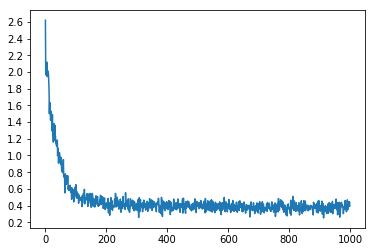

In [69]:
MAX_LENGTH = 20
batches = 100000 # In this case, the PyTorch train_per_epoch() and train() code is using batch_size=1
hidden_size = 100

my_encoder = EncoderRNN(len(singlish_vocab), hidden_size)
my_decoder = DecoderRNN(hidden_size, len(english_vocab))

if use_cuda:
    my_encoder = my_encoder.cuda()
    my_decoder = my_decoder.cuda()

train(my_encoder, my_decoder, batches, print_every=100)

# Before moving on, SAVE THE MODELS!!!

In [75]:
# Here's a nice bleeding edge Python trick, (only works on Python3.6)
# F-strings for the win!!
# See https://www.python.org/dev/peps/pep-0498/
print(hidden_size, batches)
print(f'encoder_vanilla_{hidden_size}_{batches}.pkl')

100 100000
encoder_vanilla_100_100000.pkl


In [76]:
import pickle 

# In Python >= 3.6
with open(f'encoder_vanilla_{hidden_size}_{batches}.pkl', 'wb') as fout:
    pickle.dump(my_encoder, fout)
with open(f'decoder_vanilla_{hidden_size}_{batches}.pkl', 'wb') as fout:
    pickle.dump(my_decoder, fout)

# For Python < 3.6
with open('encoder_vanilla_{}_{}.pkl'.format(hidden_size, batches), 'wb') as fout:
    pickle.dump(my_encoder, fout)
with open('decoder_vanilla_{}_{}.pkl'.format(hidden_size, batches), 'wb') as fout:
    pickle.dump(my_decoder, fout)

In [83]:
translate('kopi siew dai')

[0, 3, 5, 13, 4, 12, 23, 4, 1]


'coffee with less sugar but and sugar'

In [84]:
translate('Kopi gau siew dai peng')

[0, 21, 22, 3, 5, 6, 7, 1]


'strong iced coffee with condensed milk'

In [87]:
translate('Kopi O gau')

[0, 21, 2, 3, 5, 4, 1]


'strong black coffee with sugar'

In [90]:
translate('Teh poh')

[0, 88, 29, 65, 29, 19, 6, 7, 76, 78, 74, 77, 65, 1]


'weak tea . tea water condensed milk to dilute the beverage .'

In [91]:
translate('kopi tiloh')

[0, 82, 26, 83, 84, 61, 3, 5, 59, 19, 57, 81, 80, 76, 74, 70, 67, 1]


'heaviest , purest version of coffee with no water added at all to the initial brew'

In [96]:
translate('kopi c peng')

[0, 22, 2, 3, 5, 7, 1]


'iced black coffee with milk'

Congratulations!!!
====

If you've made it this far down the notebook, you desire a pat on the back!

You have successfully trained a Sequence-to-Sequence model in PyTorch. It's a first step towards bleeding edge developments in Natural Language Process (NLP) with deep learning. 


----

But the translator is far from great and the kopi uncle/auntie is going to stare blankly at you and say, "Huh?!". <br>
So here's some next steps that you can take to improve the model =)

3.0. Next Steps
====

Our code above implemented the basic single layer Elman network ([Elman, 1990](https://web.stanford.edu/group/pdplab/pdphandbook/handbookch8.html)), aka. Simple Recurrent Network (SRN), aka. vanilla RNN but we replace the neural network cell with Gated Recurrent Unit (GRU) ([Cho et al. 2014](https://arxiv.org/abs/1406.1078))

There are several things that we can do to improve the model and the [PyTorch tutorial on Seq2Seq](http://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html) gave a detailed exploration on

 - teacher forcing ([Williams and Zipser, 1989](http://ieeexplore.ieee.org/document/6795228/)) 
 - attention context [(Bahdanau et al. 2015)](https://arxiv.org/abs/1409.0473)


For the impatient, here's a pre-trained models with teacher forcing that you can play with on https://goo.gl/TVbW5u:

-----
 


DataScience SG Meetup (Jan 18) Epilogue 
====

Sorry to keep you guys waiting for the slides and code, I cleaned up the code a little more and added more text explanations so that the notebook is more readable. 

To those that sat through watching me code the `???` in the DataScience SG meetup, thank you all for coming for the meetup grinding through neural net crash course and code walkthrough. 

Hopefully, you had picked up a few tricks in NLP, PyTorch and/or implementing the Seq2Seq model.

I had fun going through the code together and chatting with you all after the talk. Thank you all again!